In [2]:
import json
import os
from collections import defaultdict

import pandas
import pandas as pd
from matplotlib.pyplot import savefig
from scipy.stats import spearmanr
from sklearn.decomposition import PCA

from src.features.perspective import parse_summary_scores
import seaborn as sns

import numpy as np
from matplotlib import pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
import lxml
from src.visualization.mca import plot_mca

In [3]:
parents = pd.read_json('../data/interim/labeled_contributions_nobots.jsonl', lines=True, orient='records')

In [4]:
direct_labeling_fullnames = set(pd.read_csv('../data/interim/direct_labeling_strategy_4s.csv', index_col=0).fullname)
with pd.read_json('../data/interim/labeling_contributions_preprocessed_no_bot.jsonl', orient='records', lines=True, chunksize=500) as reader:
    labeling = pd.concat(chunk[chunk.fullname.isin(direct_labeling_fullnames)][[ 'author', 'created_utc',
           'subreddit','text', 'fullname', 'parent_fullname',
           'link_fullname',]] for chunk in reader)

In [5]:
labeling_pairs = pd.merge(labeling.loc[~labeling.author.isin({'[removed]', '[deleted]'}), ['author', 'fullname', 'parent_fullname']], parents[['author', 'fullname']], left_on='parent_fullname', right_on='fullname', how='inner', suffixes=['', '_parent'])

In [6]:
del labeling_pairs['fullname_parent']

In [7]:
with open('../data/interim/labeler_sub_dimensions.jsonl', encoding='utf8') as f:
    dims = dict()
    for obj in map(json.loads, f):
        dims.update(obj)
dims_df = pd.DataFrame(dims).T

with open('../data/interim/labeler_sub_conspiracy.jsonl', encoding='utf8') as f:
    consp = dict()
    for obj in map(json.loads, f):
        consp.update(obj)

consp_df=pd.DataFrame.from_dict(consp, orient='index')
consp_df.columns=['conspiracy']
labeler_df = pd.merge(consp_df, dims_df, left_index=True, right_index=True)

In [8]:
with open('../data/interim/labeled_sub_dimensions.jsonl', encoding='utf8') as f:
    dims = dict()
    for obj in map(json.loads, f):
        dims.update(obj)
dims_df = pd.DataFrame(dims).T

with open('../data/interim/labeled_sub_conspiracy.jsonl', encoding='utf8') as f:
    consp = dict()
    for obj in map(json.loads, f):
        consp.update(obj)

consp_df=pd.DataFrame.from_dict(consp, orient='index')
consp_df.columns=['conspiracy']
labeled_df = pd.merge(consp_df, dims_df, left_index=True, right_index=True)

In [9]:
user_cols = ['conspiracy', 'affluence', 'age', 'edginess', 'partisan', 'partisan neutral', 'sociality', 'time']

In [10]:
labeling_pairs = pd.merge(labeling_pairs, labeler_df[user_cols], left_on='author', right_index=True)

In [11]:
labeling_pairs = pd.merge(labeling_pairs, labeled_df[user_cols], left_on='author_parent', right_index=True, suffixes=['', '_parent'])

In [12]:
len(labeling_pairs), len(labeler_df), len(labeled_df)

(3806, 560366, 3847)

In [358]:
labeling_pairs[user_cols+[f'{c}_parent' for c in user_cols]].corr()

,conspiracy,affluence,age,edginess,partisan,partisan neutral,sociality,time,conspiracy_parent,affluence_parent,age_parent,edginess_parent,partisan_parent,partisan neutral_parent,sociality_parent,time_parent
conspiracy,1.000000,-0.062946,0.141958,0.359308,0.408378,0.454704,-0.200956,0.142185,0.296248,0.062910,0.091463,0.150573,0.138397,0.219460,-0.126306,0.033684
affluence,-0.062946,1.000000,0.469156,0.082701,-0.078557,0.274432,-0.333968,-0.267923,0.037396,0.387420,0.197696,0.107113,-0.006319,0.173811,-0.184867,-0.107164
age,0.141958,0.469156,1.000000,0.175407,-0.258119,0.367694,-0.731000,-0.486067,0.051544,0.226679,0.389171,0.089935,-0.085255,0.158124,-0.297684,-0.195532
edginess,0.359308,0.082701,0.175407,1.000000,0.400970,0.315210,-0.423124,-0.283037,0.143529,0.107043,0.099551,0.346141,0.153952,0.204383,-0.195429,-0.072675
partisan,0.408378,-0.078557,-0.258119,0.400970,1.000000,0.113271,0.096309,0.252882,0.150200,-0.012272,-0.076002,0.137242,0.307701,0.099614,0.014065,0.106015
partisan neutral,0.454704,0.274432,0.367694,0.315210,0.113271,1.000000,-0.466818,0.029662,0.179356,0.178999,0.173189,0.181328,0.071808,0.432951,-0.240565,0.017773
sociality,-0.200956,-0.333968,-0.731000,-0.423124,0.096309,-0.466818,1.000000,0.591987,-0.081626,-0.198597,-0.300080,-0.190995,0.017120,-0.235298,0.387325,0.222619
time,0.142185,-0.267923,-0.486067,-0.283037,0.252882,0.029662,0.591987,1.000000,0.035037,-0.125951,-0.194374,-0.120970,0.086593,-0.015876,0.224695,0.341531
conspiracy_parent,0.296248,0.037396,0.051544,0.143529,0.150200,0.179356,-0.081626,0.035037,1.000000,-0.130019,0.180130,0.426534,0.451663,0.460109,-0.289627,0.119281
affluence_parent,0.062910,0.387420,0.226679,0.107043,-0.012272,0.178999,-0.198597,-0.125951,-0.130019,1.000000,0.411093,-0.002603,-0.126579,0.289897,-0.291647,-0.176931


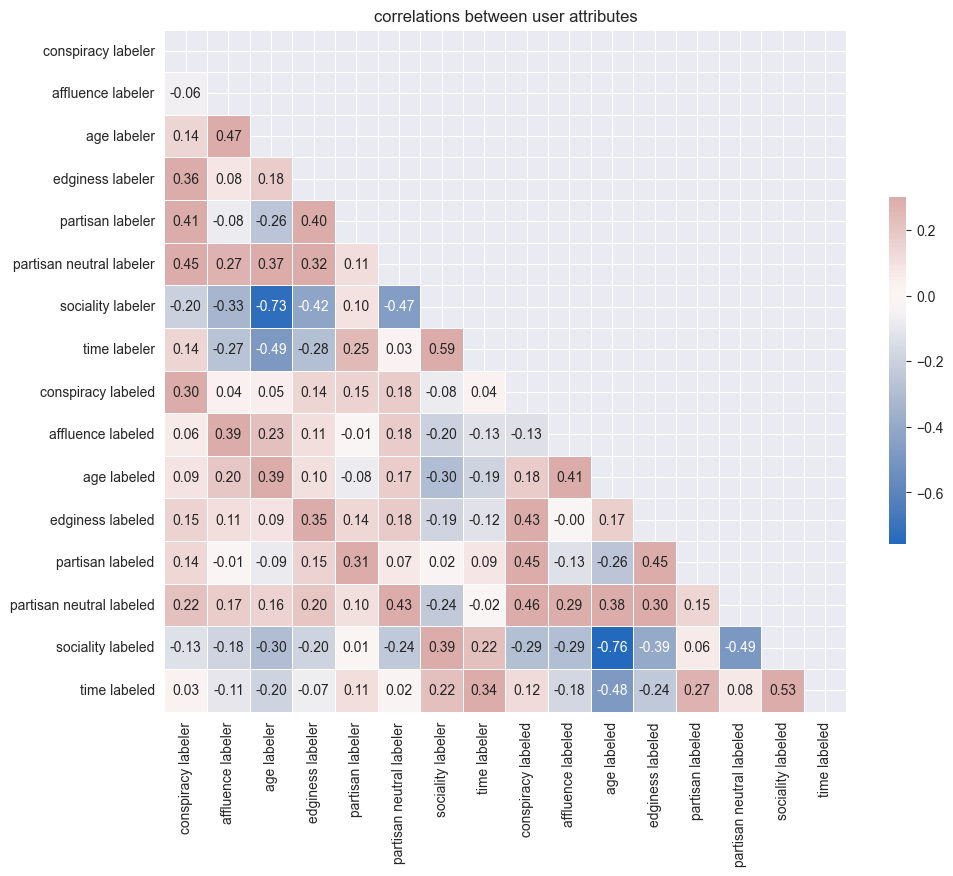

In [13]:

# Compute the correlation matrix
corr = labeling_pairs[user_cols+[f'{c}_parent' for c in user_cols]].rename(columns=lambda x: x.split('_')[0] +' labeled' if '_' in x else x+' labeler').corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)
with sns.axes_style("white"):
    # Draw the heatmap with the mask and correct aspect ratio
    ax=sns.heatmap(corr, mask=mask, #cmap=cmap,
                vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, cmap='vlag', annot=True, fmt='.2f')
    _=ax.set_title('correlations between user attributes')
    _ = savefig(f'../reports/figures/labeler_labeled_attribute_correlation.png', dpi=300, transparent=False)
    _ = savefig(f'../reports/figures/labeler_labeled_attribute_correlation.pdf', transparent=False, bbox_inches='tight', )

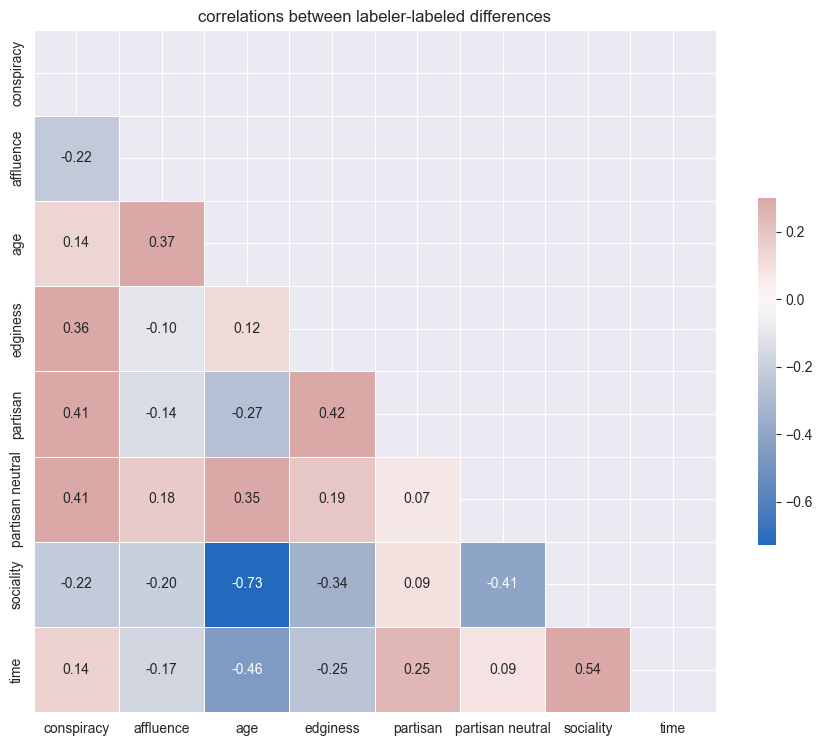

In [14]:
diff_df= pd.DataFrame(
    {col: labeling_pairs[col] - labeling_pairs[f'{col}_parent'] for col in user_cols})
# Compute the correlation matrix
corr = diff_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr, mask=mask, #cmap=cmap,
                vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, cmap='vlag', annot=True, fmt='.2f')

_=ax.set_title('correlations between labeler-labeled differences')
_ = savefig(f'../reports/figures/labeler_labeled_attribute_difference_correlation.png', dpi=300, transparent=False)
_ = savefig(f'../reports/figures/labeler_labeled_attribute_difference_correlation.pdf', transparent=False, bbox_inches='tight', )


    1.Zollo, F. et al. Emotional Dynamics in the Age of Misinformation. PLoS ONE 10, e0138740 (2015).
  

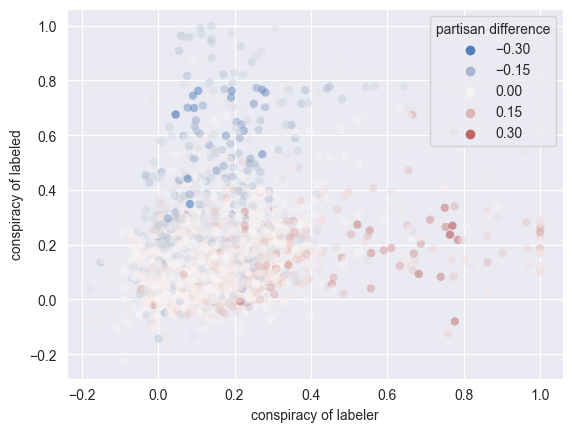

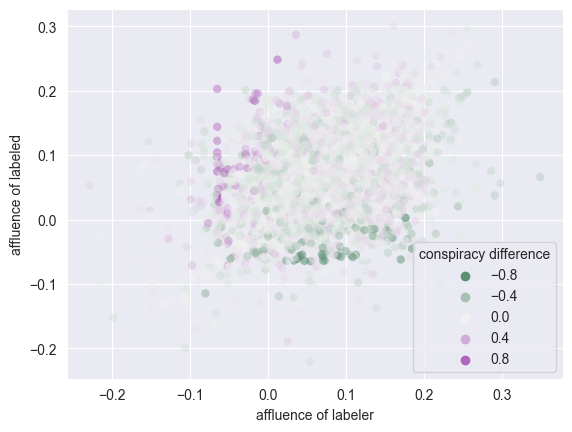

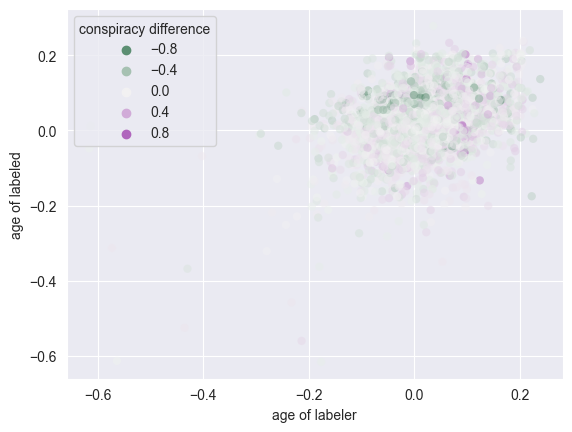

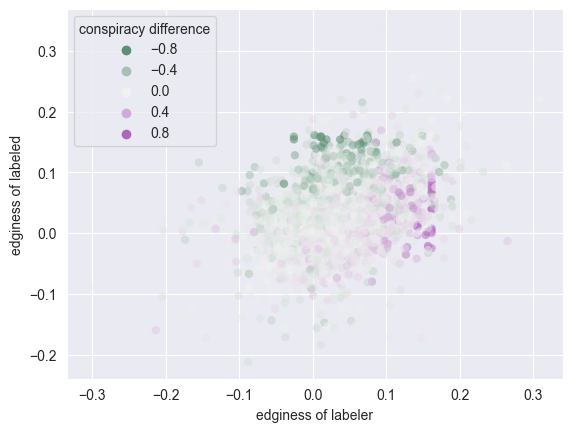

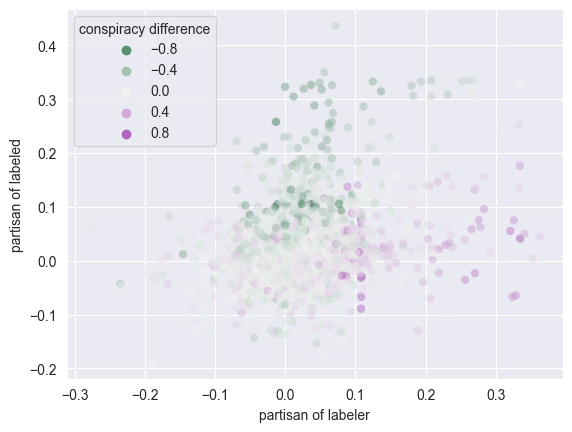

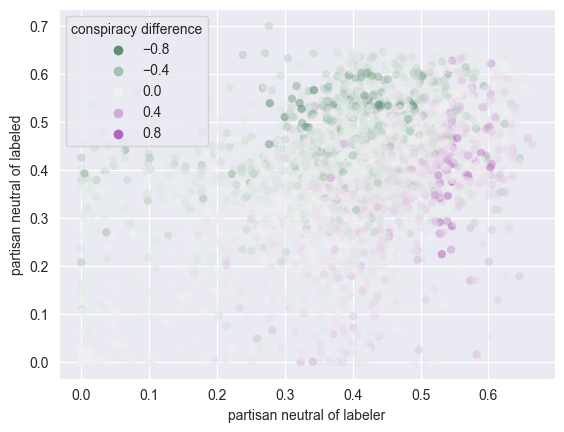

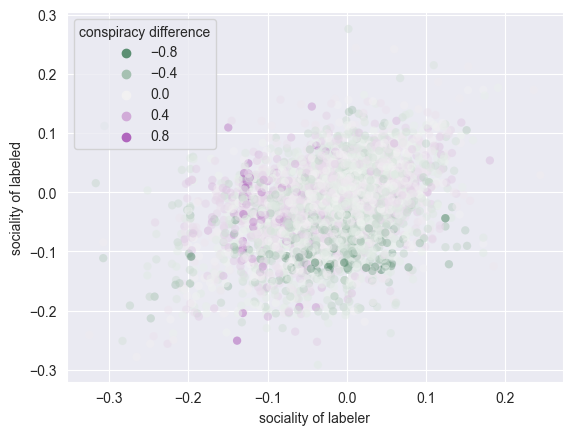

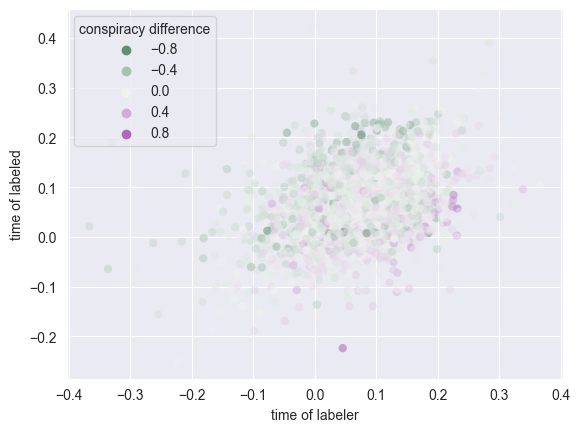

In [15]:

for col in user_cols:
    ax = sns.scatterplot(labeling_pairs, x=col, y=f'{col}_parent', alpha = .5,
                         hue=labeling_pairs.conspiracy-labeling_pairs.conspiracy_parent if col != 'conspiracy' else labeling_pairs.partisan-labeling_pairs.partisan_parent ,
                         # size=None if col != 'conspiracy' else labeling_pairs.affluence-labeling_pairs.affluence_parent,
                         palette=sns.diverging_palette(145, 300, s=60, as_cmap=True)if col != 'conspiracy' else 'vlag',
                         linewidth=0)
    ax.set_xlabel(f'{col} of labeler')
    ax.set_ylabel(f'{col} of labeled')
    ax.legend(title='conspiracy difference' if col != 'conspiracy' else 'partisan difference')
    savefig(f'../reports/figures/{col}_labeler_labeled_scatter.png', dpi=300, transparent=False)
    savefig(f'../reports/figures/{col}_labeler_labeled_scatter.pdf', transparent=False, bbox_inches='tight', )
    plt.show()

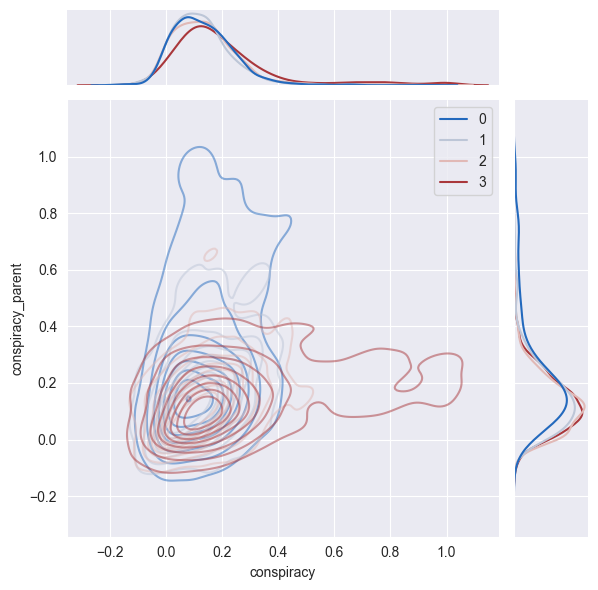

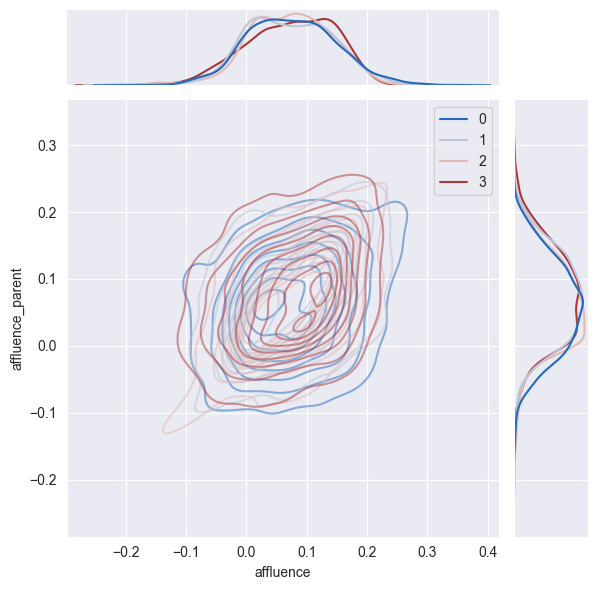

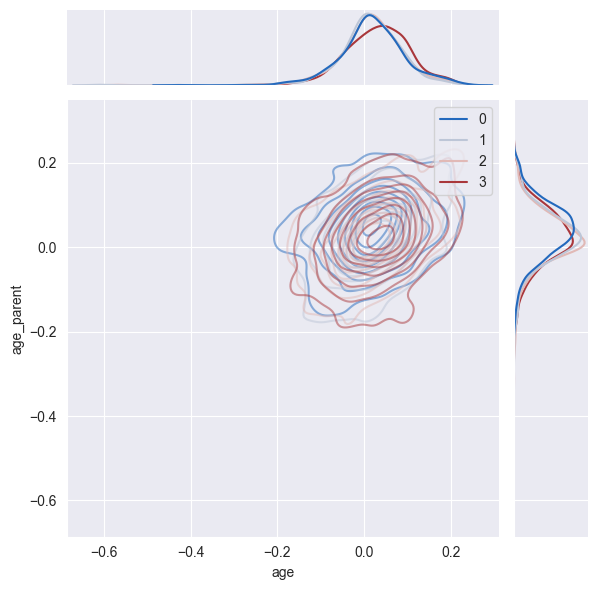

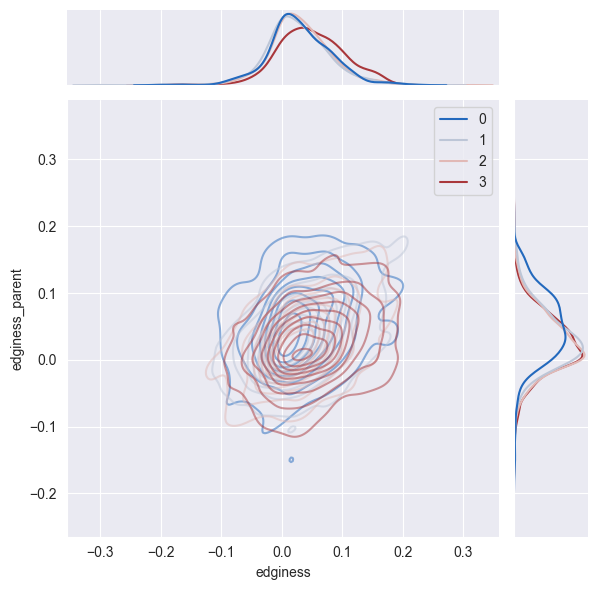

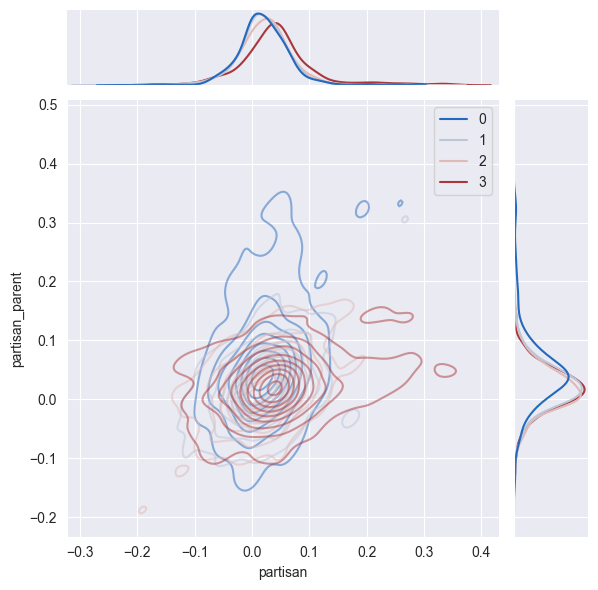

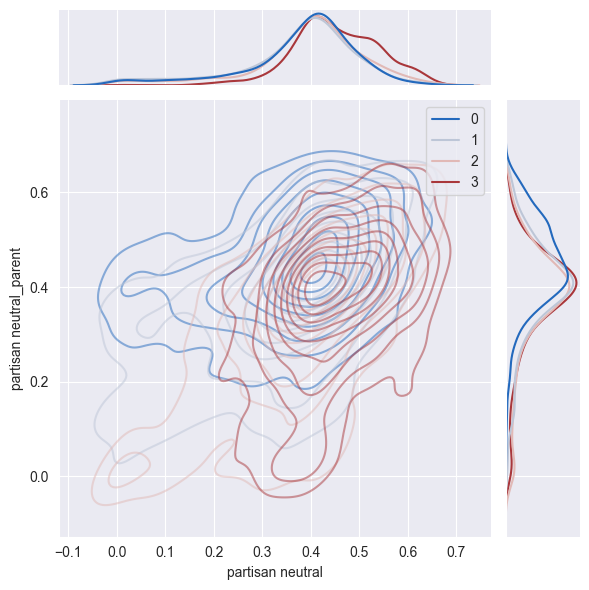

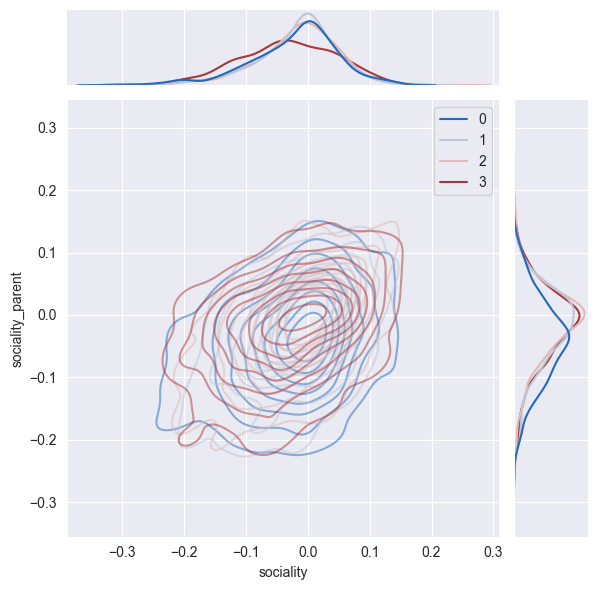

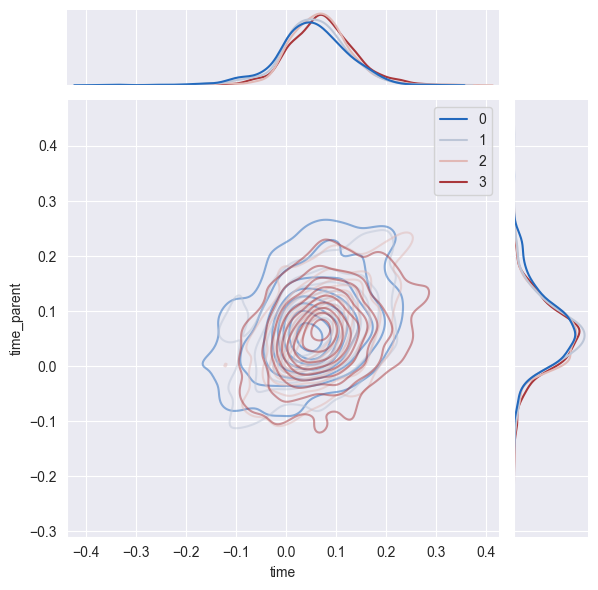

In [372]:

for col in user_cols:
    ax = sns.jointplot(labeling_pairs, x=col, y=f'{col}_parent', alpha = .5,
                         hue=pd.qcut(labeling_pairs.conspiracy-labeling_pairs.conspiracy_parent, 4, labels=False) if col != 'conspiracy' else pd.qcut(labeling_pairs.partisan-labeling_pairs.partisan_parent, 4, labels=False) ,
                         # size=None if col != 'conspiracy' else labeling_pairs.affluence-labeling_pairs.affluence_parent,
                         palette='vlag',
                       kind='kde',)
    # ax.set_xlabel(f'{col} of labeler')
    # ax.set_ylabel(f'{col} of labeled')
    # ax.legend(title='conspiracy difference' if col != 'conspiracy' else 'partisan difference')
    # savefig(f'../reports/figures/{col}_labeler_labeled_scatter.png', dpi=300, transparent=False)
    # savefig(f'../reports/figures/{col}_labeler_labeled_scatter.pdf', transparent=False, bbox_inches='tight', )
    plt.show()

F:\PycharmProjects\thrutherstoo\venv\lib\site-packages\seaborn\axisgrid.py:848: UserWarning:

Ignoring `ax`; jointplot is a figure-level function.



ValueError: Could not interpret value `conspiracy` for parameter `x`

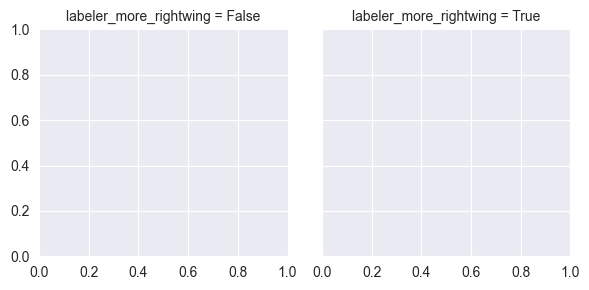

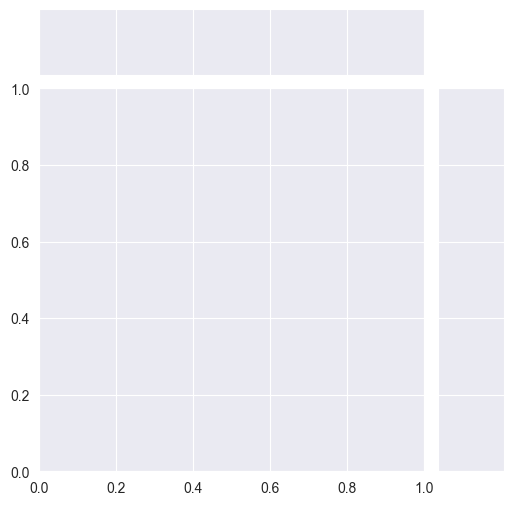

In [375]:
labeling_pairs['labeler_more_conspiracist'] = labeling_pairs.conspiracy-labeling_pairs.conspiracy_parent>0
labeling_pairs['labeler_more_rightwing'] = labeling_pairs.partisan-labeling_pairs.partisan_parent>0
for col in user_cols:
    g = sns.FacetGrid(labeling_pairs, 
                         hue='labeler_more_conspiracist' if col != 'conspiracy' else 'labeler_more_rightwing',
                       col='labeler_more_conspiracist' if col != 'conspiracy' else 'labeler_more_rightwing',
                         # size=None if col != 'conspiracy' else labeling_pairs.affluence-labeling_pairs.affluence_parent,
                         )
    ax = g.map(sns.jointplot, x=col, y=f'{col}_parent', alpha = .5,palette='vlag',
                       kind='hex',)
    
    # ax.set_xlabel(f'{col} of labeler')
    # ax.set_ylabel(f'{col} of labeled')
    # ax.legend(title='conspiracy difference' if col != 'conspiracy' else 'partisan difference')
    # savefig(f'../reports/figures/{col}_labeler_labeled_scatter.png', dpi=300, transparent=False)
    # savefig(f'../reports/figures/{col}_labeler_labeled_scatter.pdf', transparent=False, bbox_inches='tight', )
    plt.show()

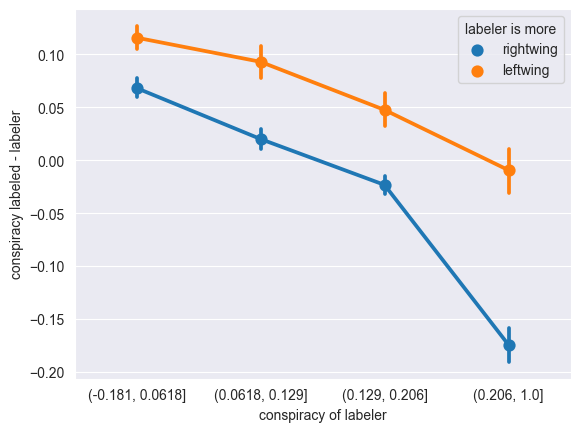

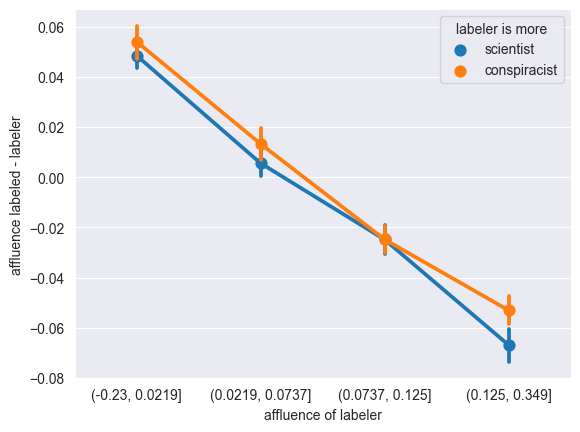

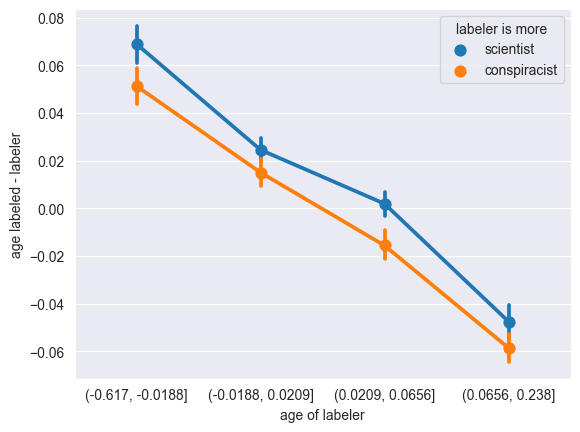

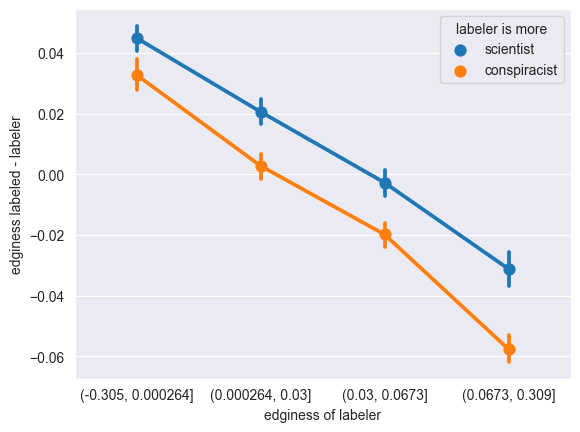

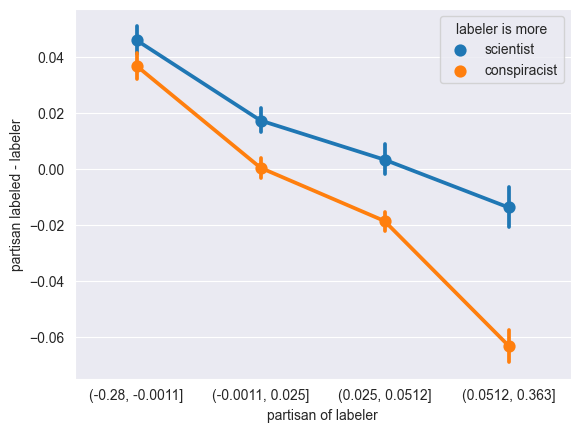

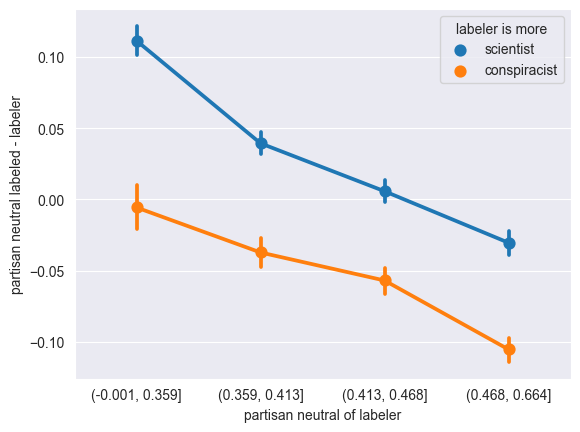

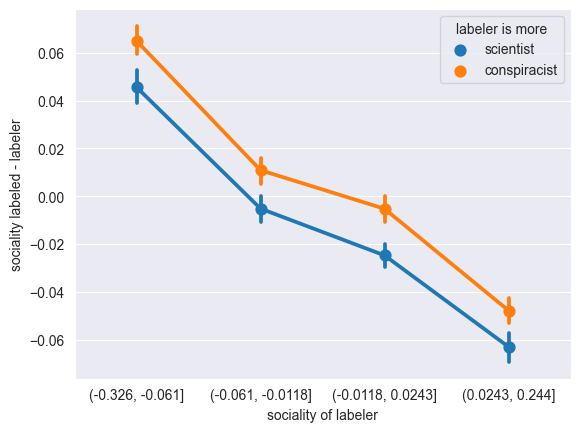

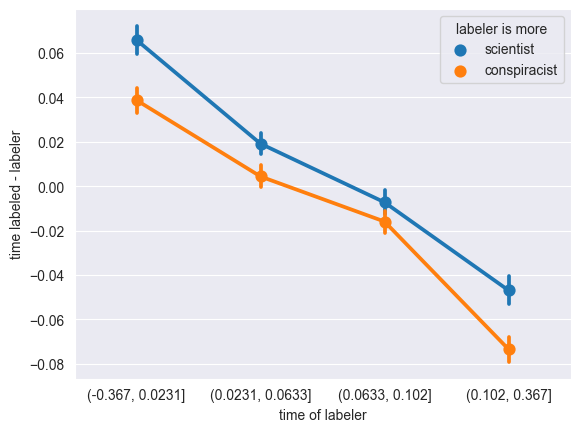

In [16]:

for col in user_cols:
    ax = sns.pointplot(x=pd.qcut(labeling_pairs[col], 4, ), y=labeling_pairs[f'{col}_parent']-labeling_pairs[f'{col}'],
                         hue=((labeling_pairs.conspiracy-labeling_pairs.conspiracy_parent)>0).map({True:'conspiracist', False:'scientist'})
                         if col != 'conspiracy' else ((labeling_pairs.partisan-labeling_pairs.partisan_parent)>0).map({True:'rightwing',False:'leftwing'}) ,
                         # size=None if col != 'conspiracy' else labeling_pairs.affluence-labeling_pairs.affluence_parent,
                         # palette=sns.diverging_palette(145, 300, s=60, as_cmap=True)if col != 'conspiracy' else 'vlag',
                         # linewidth=0
                       )
    ax.set_xlabel(f'{col} of labeler')
    ax.set_ylabel(f'{col} labeled - labeler')
    ax.legend(title='labeler is more' if col != 'conspiracy' else 'labeler is more')
    # savefig(f'../reports/figures/{col}_labeler_labeled_scatter.png', dpi=300, transparent=False)
    # savefig(f'../reports/figures/{col}_labeler_labeled_scatter.pdf', transparent=False, bbox_inches='tight', )
    plt.show()

In [13]:

with pd.read_json('../data/interim/labeling_contributions_preprocessed_no_bot.jsonl', orient='records', lines=True, chunksize=500) as reader:
    df = pd.concat(chunk[chunk.contribution_type=='comment'][[ 'author', 'created_utc',
           'subreddit','text', 'fullname', 'parent_fullname',
           'link_fullname',]] for chunk in reader)

with open('../data/interim/perspective/labeling_contributions_preprocessed_no_bot_perspective.jsonl', encoding='utf8') as f:
    perspectives = dict()
    for obj in map(json.loads, f):
        k, v = list(obj.items())[0]
        perspectives[k] = parse_summary_scores(v)
perspective_df = pd.DataFrame(perspectives).T


with open('../data/interim/liwc/labeling_contributions_preprocessed_no_bot_liwc.jsonl', encoding='utf8') as f:
    liwcs = dict()
    for obj in map(json.loads, f):
        liwcs.update(obj)
liwc_df = pd.DataFrame(liwcs).T
liwc_df = liwc_df.divide(liwc_df.Tokens, axis=0)
del liwc_df['Tokens']
with open('../data/interim/social_dimensions/labeling_contributions_preprocessed_no_bot_social_dimensions.jsonl', encoding='utf8') as f:
    social_dimensions = dict()
    for obj in map(json.loads, f):
        social_dimensions.update(obj)
social_dimensions_df = pd.DataFrame(social_dimensions).T


df = pd.merge(df, perspective_df, how='left', left_on='fullname', right_index=True)
df = pd.merge(df, social_dimensions_df, how='left', left_on='fullname', right_index=True)
df = pd.merge(df, liwc_df, how='left', left_on='fullname', right_index=True)

del perspective_df, social_dimensions_df, liwc_df,perspectives, liwcs, social_dimensions

In [14]:
list(df.columns)

liwc_cols = ['Adverb',
 'Affect',
 'Article',
 'Auxverb',
 'Cause',
 'CogProc',
 'Conj',
 'Discrep',
 'FocusPresent',
 'Function',
 'Insight',
 'Ipron',
 'Posemo',
 'Ppron',
 'Pronoun',
 'Quant',
 'Social',
 'Tentat',
 'Verb',
 'You',
 'friend',
 'Tokens',
 'Achieve',
 'Adj',
 'Compare',
 'Drives',
 'I',
 'Motion',
 'Prep',
 'Relativ',
 'Reward',
 'Space',
 'they',
 'FocusFuture',
 'FocusPast',
 'Interrog',
 'SheHe',
 'differ',
 'male',
 'Anx',
 'Assent',
 'Bio',
 'Certain',
 'Health',
 'Informal',
 'Money',
 'Negate',
 'Negemo',
 'Netspeak',
 'Percept',
 'Power',
 'Relig',
 'Risk',
 'Sad',
 'Time',
 'feel',
 'Anger',
 'Body',
 'Death',
 'Nonflu',
 'See',
 'Swear',
 'female',
 'Affiliation',
 'Leisure',
 'Sexual',
 'family',
 'Ingest',
 'Work',
 'hear',
 'We',
 'home',
 'Filler']
social_cols=['conflict',
 'fun',
 'identity',
 'knowledge',
 'power',
 'respect',
 'romance',
 'similarity',
 'social_support',
 'trust',]
toxic_cols=['ATTACK_ON_AUTHOR',
 'ATTACK_ON_COMMENTER',
 'FLIRTATION',
 'IDENTITY_ATTACK',
 'INCOHERENT',
 'INFLAMMATORY',
 'INSULT',
 'LIKELY_TO_REJECT',
 'OBSCENE',
 'PROFANITY',
 'SEVERE_TOXICITY',
 'SEXUALLY_EXPLICIT',
 'SPAM',
 'THREAT',
 'TOXICITY',
 'UNSUBSTANTIAL',]

In [15]:
df.head()

,author,created_utc,subreddit,text,fullname,parent_fullname,link_fullname,ATTACK_ON_AUTHOR,ATTACK_ON_COMMENTER,FLIRTATION,...,Assent,family,FocusFuture,Ingest,female,feel,Death,Money,home,Filler
16063,martin77,1135966642,reddit.com,would the person who marked this post down\r\n...,t1_c2608,t3_22406,t3_22406,0.103066,0.870031,0.260568,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
16064,madmonky1,1137434271,reddit.com,"&gt;Any other rational person, who isn't too f...",t1_c6146,t1_c6070,t3_27340,0.166237,0.005013,0.226688,...,0.0,0.0,0.012295,0.004098,0.0,0.000000,0.000000,0.000000,0.0,0.0
16065,bigheadarmy,1138919169,reddit.com,"With regard to the blathering, my dismissal co...",t1_c17zz,t1_c17z7,t3_17mn,0.006155,0.006703,0.387258,...,0.0,0.0,0.023973,0.000000,0.0,0.003425,0.006849,0.003425,0.0,0.0
16066,the_seanald,1139327062,reddit.com,What do you say to all these conspiracy theori...,t1_c1bq8,t3_1b0p,t3_1b0p,0.043987,0.737867,0.220544,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
16067,Alex3917,1144197420,reddit.com,Jon Ronson devoted a large part of his book on...,t1_c3xes,t3_3x9b,t3_3x9b,0.474516,0.135797,0.191341,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0


In [16]:
user_df = labeler_df
user_df.head()

,conspiracy,affluence,age,age B,age neutral,edginess,gender,gender B,gender neutral,partisan,partisan B,partisan B neutral,partisan neutral,sociality,time
GallowFroot,0.162281,0.080235,-0.046192,-0.059004,0.493092,0.063367,-0.024410,0.026420,0.431664,0.076811,0.063858,0.416249,0.420440,0.033946,0.124584
lie-twerker,0.334199,-0.078243,-0.052892,-0.016210,0.423090,-0.004301,0.187111,0.211298,0.403782,0.053580,0.105483,0.349728,0.306543,0.138508,0.121835
arduous_raven,0.062335,0.188243,-0.023091,-0.011270,0.521908,0.036400,-0.033094,0.018579,0.441465,0.014570,-0.026937,0.401205,0.440431,0.043603,0.083971
thrawnpop,0.086708,-0.004740,0.022127,0.030912,0.065832,0.017135,0.012276,-0.003803,0.051026,-0.002335,0.010144,0.060803,0.055966,-0.017333,-0.004110
SPACEMANTIMEZ,0.297257,0.162604,0.061887,0.021390,0.519869,0.001225,0.097639,0.090844,0.483203,-0.008656,-0.042643,0.513038,0.491142,-0.039786,0.033664


In [17]:
# attempt hierarchical modeling

to_regress = pd.merge(df, user_df, how='left', left_on='author', right_index=True)

In [78]:
for col in [i for i in liwc_cols+toxic_cols+social_cols if i in to_regress.columns]:
    to_regress[col] -= to_regress[col].mean()
    to_regress[col] /= to_regress[col].std()

In [79]:

target_var = 'conspiracy'
md = smf.mixedlm(f"{target_var} ~ {'+'.join(toxic_cols)}", data=to_regress.dropna().sample(1000), groups="author", re_formula='+'.join(['affluence', 'age', 'partisan', 'sociality', 'time']))
mdf = md.fit()
print(mdf.summary())

F:\PycharmProjects\thrutherstoo\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
F:\PycharmProjects\thrutherstoo\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
F:\PycharmProjects\thrutherstoo\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     conspiracy
No. Observations:     1000        Method:                 REML      
No. Groups:           996         Scale:                  0.0020    
Min. group size:      1           Log-Likelihood:         803.2618  
Max. group size:      2           Converged:              Yes       
Mean group size:      1.0                                           
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.107    0.004 28.016 0.000  0.100  0.115
ATTACK_ON_AUTHOR          -0.004    0.003 -1.244 0.213 -0.011  0.002
ATTACK_ON_COMMENTER        0.005    0.004  1.332 0.183 -0.003  0.013
FLIRTATION                -0.001    0.004 -0.387 0.699 -0.008  0.006
IDENTITY_ATTACK           -0.002    0.004 -0.483 0

strange finding: toxicity correlated with being leftwing

In [99]:
def plot_statsmodels(mdf, dep_var, figsize=( 5, 20,)):
    results_summary = mdf.summary()
    
    results_as_html = results_summary.tables[1].as_html()
    model_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
    model_df['coef_abs'] =model_df.coef.abs() 
    model_df = model_df.sort_values(by='coef_abs', ascending=True)
    
    model_df['color'] = (model_df['P>|t|'].apply(lambda x: 'blue' if x<.05 else 'gray') )
    model_df.drop('Intercept', inplace=True)
    fig = plt.figure(figsize=figsize)
    ax = model_df.reset_index(names='variable').plot(kind='scatter', x='coef', y='variable', ax=plt.gca(), xerr=((model_df['coef']-model_df['[0.025']).abs(), (model_df['0.975]']-model_df['coef']).abs()), 
                                                color=model_df['color'].tolist(),)
    _=ax.set_xlabel(dep_var)
    plt.show()

                            OLS Regression Results                            
Dep. Variable:               TOXICITY   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     551.6
Date:                Fri, 01 Dec 2023   Prob (F-statistic):               0.00
Time:                        14:27:29   Log-Likelihood:            -7.2889e+05
No. Observations:              544886   AIC:                         1.458e+06
Df Residuals:                  544881   BIC:                         1.458e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0183      0.002     -8.228      0.0

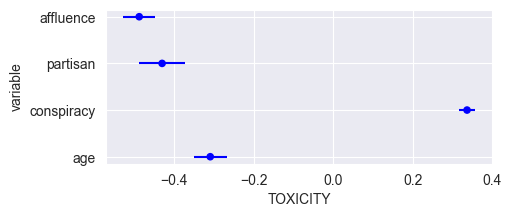

In [106]:
dep_var = 'TOXICITY'
indep_vars = ['conspiracy', 'affluence', 'age', 'partisan', #'sociality', 'time'
              ]
group='author'
md = smf.ols(f"{dep_var} ~ {'+'.join(indep_vars)}", data=to_regress[[dep_var, group]+indep_vars].dropna().groupby([group]+indep_vars).mean().reset_index())
# md = smf.mixedlm(f"{dep_var} ~ {'+'.join(indep_vars)}", data=to_regress[[dep_var, group]+indep_vars].dropna(), groups=group)
mdf = md.fit()
print(mdf.summary())
plot_statsmodels(mdf, dep_var, (5, 2))

                            OLS Regression Results                            
Dep. Variable:             conspiracy   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     136.3
Date:                Mon, 27 Nov 2023   Prob (F-statistic):               0.00
Time:                        18:57:42   Log-Likelihood:             4.9356e+05
No. Observations:             1083699   AIC:                        -9.869e+05
Df Residuals:                 1083600   BIC:                        -9.857e+05
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.1452    

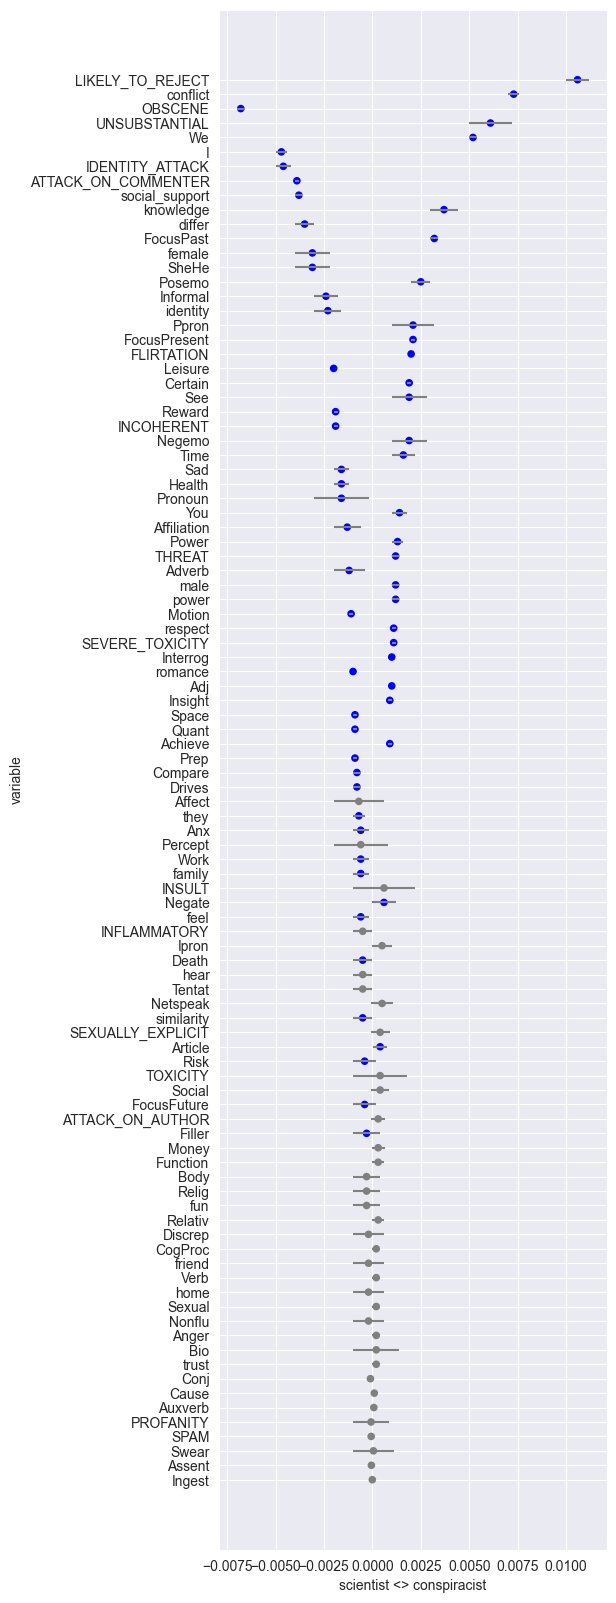

In [103]:
dep_var = 'conspiracy'
indep_vars = [i for i in liwc_cols if i in to_regress.columns]+toxic_cols+social_cols
group='author'
md = smf.ols(f"{dep_var} ~ {'+'.join(indep_vars)}", data=to_regress[[dep_var, group]+indep_vars].dropna().groupby([group]+indep_vars).mean().reset_index())
# md = smf.mixedlm(f"{dep_var} ~ {'+'.join(indep_vars)}", data=to_regress[[dep_var, group]+indep_vars].dropna(), groups=group)
mdf = md.fit()
print(mdf.summary())
plot_statsmodels(mdf, 'scientist <> conspiracist')

In [101]:
dep_var = 'partisan'
indep_vars = [i for i in liwc_cols if i in to_regress.columns]+toxic_cols+social_cols
group='author'
md = smf.ols(f"{dep_var} ~ {'+'.join(indep_vars)}", data=to_regress[[dep_var, group]+indep_vars].dropna().groupby([group]+indep_vars).mean().reset_index())
# md = smf.mixedlm(f"{dep_var} ~ {'+'.join(indep_vars)}", data=to_regress[[dep_var, group]+indep_vars].dropna(), groups=group)
mdf = md.fit()
print(mdf.summary())

                            OLS Regression Results                            
Dep. Variable:               partisan   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     105.8
Date:                Mon, 27 Nov 2023   Prob (F-statistic):               0.00
Time:                        18:57:11   Log-Likelihood:             1.6338e+06
No. Observations:             1083699   AIC:                        -3.267e+06
Df Residuals:                 1083600   BIC:                        -3.266e+06
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0220   5

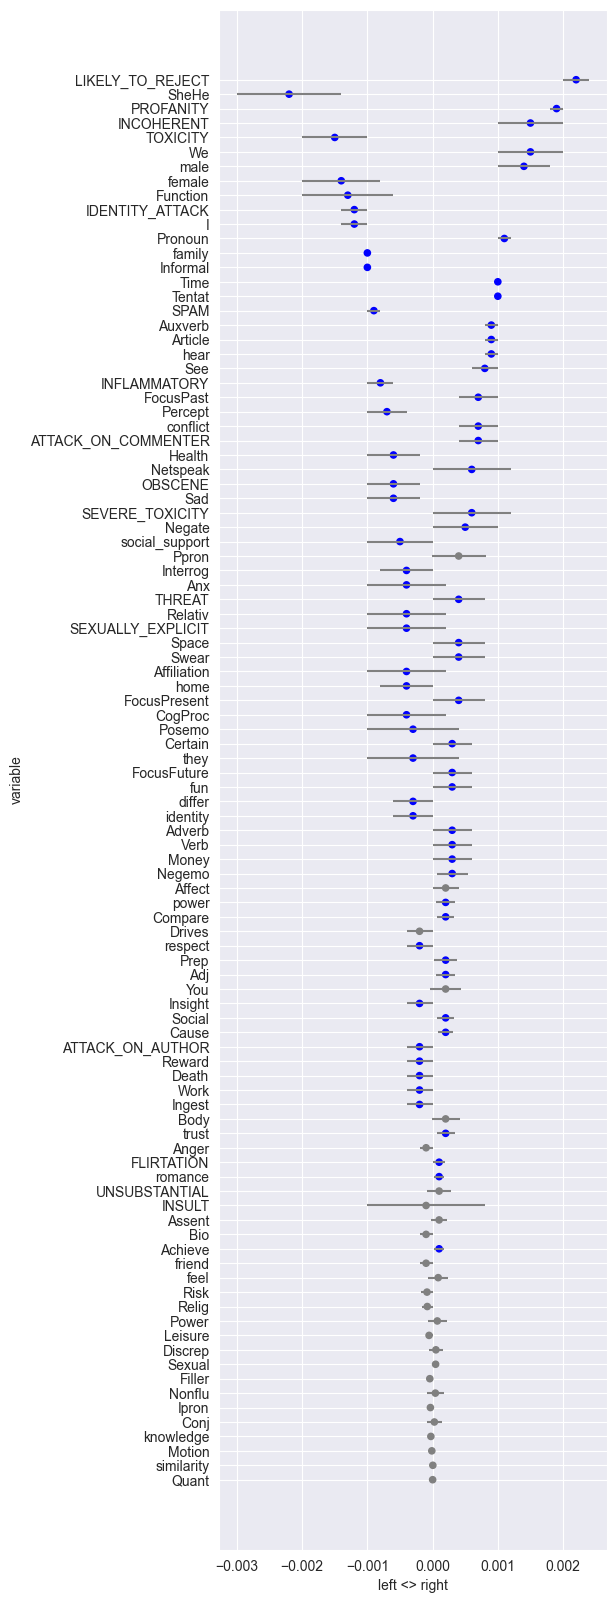

In [102]:
plot_statsmodels(mdf, 'left <> right')

In [22]:
mean_df = df[[c for c in df.columns if c not in {'created_utc', 'subreddit', 'text',
                                      'fullname',
                                      'parent_fullname', 'link_fullname'}]].groupby('author').mean()

In [23]:
mean_df.head()

,ATTACK_ON_AUTHOR,ATTACK_ON_COMMENTER,FLIRTATION,IDENTITY_ATTACK,INCOHERENT,INFLAMMATORY,INSULT,LIKELY_TO_REJECT,OBSCENE,PROFANITY,...,Affiliation,Leisure,Sexual,family,Ingest,Work,hear,We,home,Filler
author,,,,,,,,,,,,,,,,,,,,,
----------------fuck,0.081933,0.696846,0.306964,0.367026,0.686348,0.780436,0.498691,0.704208,0.051485,0.492594,...,0.029851,0.000000,0.000000,0.0,0.0,0.014925,0.029851,0.029851,0.0,0.0
---------_----_---_,0.329614,0.261148,0.320017,0.043226,0.214240,0.364906,0.519861,0.561594,0.338142,0.243875,...,0.012821,0.000000,0.000000,0.0,0.0,0.018668,0.000000,0.012821,0.0,0.0
--------V--------,0.620920,0.727617,0.203574,0.005550,0.890323,0.639493,0.072701,0.818072,0.127282,0.019964,...,0.028571,0.000000,0.000000,0.0,0.0,0.000000,0.028571,0.028571,0.0,0.0
-------_-----,0.008301,0.160138,0.198003,0.059766,0.085357,0.436962,0.392980,0.996588,0.993693,0.644600,...,0.009346,0.018692,0.009346,0.0,0.0,0.009346,0.000000,0.000000,0.0,0.0
-----1,0.358992,0.355179,0.178002,0.004532,0.501877,0.650783,0.024124,0.337144,0.010805,0.013200,...,0.023256,0.023256,0.000000,0.0,0.0,0.023256,0.023256,0.046512,0.0,0.0


In [35]:
import seaborn as sns

In [38]:
dh=mean_df.head()

In [50]:
toplot = pd.merge(mean_df.reset_index().melt(id_vars=['author']).set_index('author'), pd.qcut(user_df['conspiracy'], 2, labels=False), how='left', left_index=True, right_index=True)

In [ ]:
user_characteristics = ['affluence', 'age', 'partisan', 'sociality', 'time', 'edginess', 'gender', 'conspiracy']
sns.stripplot(data = toplot, hue='conspiracy', x='value', y='variable', )

In [118]:
means_stds = dict()
for measure in ['social_dimensions', 'liwc', 'perspective']:

    subreddit_means = pd.read_json(f'../data/interim/{measure}/sample_contributions_10000_preprocessed_{measure}_subreddit_means.jsonl',
                 lines=True).set_index('subreddit')
    subreddit_stds = pd.read_json(f'../data/interim/{measure}/sample_contributions_10000_preprocessed_{measure}_subreddit_stds.jsonl',
                lines=True).set_index('subreddit')
    means_stds[measure] = (subreddit_means, subreddit_stds)

In [128]:
subreddit_means = pd.concat((i[0] for i in means_stds.values()), axis=1)
subreddit_stds = pd.concat((i[1] for i in means_stds.values()), axis=1)

In [124]:
subreddit_stds.dropna().head()

,CogProc,Function,Insight,Prep,Relativ,Time,Work,Adverb,Article,Auxverb,...,Sad,family,Ingest,I,Discrep,SheHe,female,friend,Nonflu,Filler
subreddit,,,,,,,,,,,,,,,,,,,,,
000000000000O0000000,0.026189,0.602350,0.013095,0.078567,0.052378,0.013095,0.000000,0.052378,0.052378,0.157135,...,0.000000,0.0,0.026189,0.026189,0.026189,0.000000,0.000000,0.00000,0.000000,0.0
007,0.157459,0.161689,0.000000,0.052486,0.052486,0.052486,0.000000,0.104973,0.144338,0.041928,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0
0b0t,0.027550,0.018366,0.000000,0.096424,0.096424,0.032141,0.000000,0.036733,0.000000,0.036733,...,0.000000,0.0,0.000000,0.000000,0.064282,0.032141,0.000000,0.00000,0.000000,0.0
0sanitymemes,0.093374,0.304485,0.000000,0.060405,0.108605,0.031944,0.031944,0.104124,0.054606,0.054606,...,0.000000,0.0,0.000000,0.061871,0.061871,0.055902,0.111803,0.00000,0.000000,0.0
0x10c,0.089788,0.153697,0.046692,0.106007,0.072814,0.030073,0.008609,0.138370,0.057189,0.061136,...,0.133341,0.0,0.000000,0.089017,0.023348,0.001980,0.001980,0.00198,0.133631,0.0


In [21]:
with pd.read_json('../data/interim/labeling_contributions_preprocessed_no_bot.jsonl', orient='records', lines=True, chunksize=500) as reader:
    df = pd.concat(chunk[chunk.contribution_type=='comment'][[ 'author', 'created_utc',
           'subreddit','text', 'fullname', 'parent_fullname',
           'link_fullname',]] for chunk in reader)

with open('../data/interim/perspective/labeling_contributions_preprocessed_no_bot_perspective.jsonl', encoding='utf8') as f:
    perspectives = dict()
    for obj in map(json.loads, f):
        k, v = list(obj.items())[0]
        perspectives[k] = parse_summary_scores(v)
perspective_df = pd.DataFrame(perspectives).T


with open('../data/interim/liwc/labeling_contributions_preprocessed_no_bot_liwc.jsonl', encoding='utf8') as f:
    liwcs = dict()
    for obj in map(json.loads, f):
        liwcs.update(obj)
liwc_df = pd.DataFrame(liwcs).T
liwc_df = liwc_df.divide(liwc_df.Tokens, axis=0)
del liwc_df['Tokens']
with open('../data/interim/social_dimensions/labeling_contributions_preprocessed_no_bot_social_dimensions.jsonl', encoding='utf8') as f:
    social_dimensions = dict()
    for obj in map(json.loads, f):
        social_dimensions.update(obj)
social_dimensions_df = pd.DataFrame(social_dimensions).T


df = pd.merge(df, perspective_df, how='left', left_on='fullname', right_index=True)
df = pd.merge(df, social_dimensions_df, how='left', left_on='fullname', right_index=True)
df = pd.merge(df, liwc_df, how='left', left_on='fullname', right_index=True)

del perspective_df, social_dimensions_df, liwc_df,perspectives, liwcs, social_dimensions

In [22]:
df.head()

,author,created_utc,subreddit,text,fullname,parent_fullname,link_fullname,ATTACK_ON_AUTHOR,ATTACK_ON_COMMENTER,FLIRTATION,...,Assent,family,FocusFuture,Ingest,female,feel,Death,Money,home,Filler
16063,martin77,1135966642,reddit.com,would the person who marked this post down\r\n...,t1_c2608,t3_22406,t3_22406,0.103066,0.870031,0.260568,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
16064,madmonky1,1137434271,reddit.com,"&gt;Any other rational person, who isn't too f...",t1_c6146,t1_c6070,t3_27340,0.166237,0.005013,0.226688,...,0.0,0.0,0.012295,0.004098,0.0,0.000000,0.000000,0.000000,0.0,0.0
16065,bigheadarmy,1138919169,reddit.com,"With regard to the blathering, my dismissal co...",t1_c17zz,t1_c17z7,t3_17mn,0.006155,0.006703,0.387258,...,0.0,0.0,0.023973,0.000000,0.0,0.003425,0.006849,0.003425,0.0,0.0
16066,the_seanald,1139327062,reddit.com,What do you say to all these conspiracy theori...,t1_c1bq8,t3_1b0p,t3_1b0p,0.043987,0.737867,0.220544,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
16067,Alex3917,1144197420,reddit.com,Jon Ronson devoted a large part of his book on...,t1_c3xes,t3_3x9b,t3_3x9b,0.474516,0.135797,0.191341,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0


In [126]:
to_regress_by_subreddit = pd.merge(df, user_df, how='left', left_on='author', right_index=True)

In [143]:
target_subreddit = list(sorted(set(subreddit_means.dropna().index)&set(subreddit_stds.dropna().index)&set(to_regress_by_subreddit.dropna().subreddit)))

In [144]:
len(target_subreddit)

13194

In [152]:
to_regress_by_subreddit.subreddit.nunique()

20740

In [153]:
len(to_regress_by_subreddit), len(to_regress_by_subreddit[to_regress_by_subreddit.subreddit.isin(target_subreddit)])

(1132689, 1112450)

In [154]:
to_regress_by_subreddit = to_regress_by_subreddit[to_regress_by_subreddit.subreddit.isin(target_subreddit)]

In [155]:
subreddit_means = subreddit_means.loc[target_subreddit]
subreddit_stds = subreddit_stds.loc[target_subreddit]

In [156]:
for col in [i for i in liwc_cols+toxic_cols+social_cols if i in to_regress_by_subreddit.columns]:
    to_regress_by_subreddit[col] -= to_regress_by_subreddit.subreddit.apply(lambda x: subreddit_means.loc[x, col])
    to_regress_by_subreddit[col] /= to_regress_by_subreddit.subreddit.apply(lambda x: subreddit_stds.loc[x, col])

In [157]:
to_regress_by_subreddit.head()

,author,created_utc,subreddit,text,fullname,parent_fullname,link_fullname,ATTACK_ON_AUTHOR,ATTACK_ON_COMMENTER,FLIRTATION,...,edginess,gender,gender B,gender neutral,partisan,partisan B,partisan B neutral,partisan neutral,sociality,time
16063,martin77,1135966642,reddit.com,would the person who marked this post down\r\n...,t1_c2608,t3_22406,t3_22406,-0.191961,2.673818,-0.514330,...,0.008995,0.136209,0.055589,0.502465,-0.023369,-0.084986,0.347631,0.400243,-0.325850,-0.394882
16064,madmonky1,1137434271,reddit.com,"&gt;Any other rational person, who isn't too f...",t1_c6146,t1_c6070,t3_27340,0.151600,-0.936964,-0.788143,...,0.008995,0.136209,0.055589,0.502465,-0.023369,-0.084986,0.347631,0.400243,-0.325850,-0.394882
16065,bigheadarmy,1138919169,reddit.com,"With regard to the blathering, my dismissal co...",t1_c17zz,t1_c17z7,t3_17mn,-0.719018,-0.929911,0.509572,...,0.008995,0.136209,0.055589,0.502465,-0.023369,-0.084986,0.347631,0.400243,-0.325850,-0.394882
16066,the_seanald,1139327062,reddit.com,What do you say to all these conspiracy theori...,t1_c1bq8,t3_1b0p,t3_1b0p,-0.513269,2.122137,-0.837803,...,0.008995,0.136209,0.055589,0.502465,-0.023369,-0.084986,0.347631,0.400243,-0.325850,-0.394882
16067,Alex3917,1144197420,reddit.com,Jon Ronson devoted a large part of his book on...,t1_c3xes,t3_3x9b,t3_3x9b,1.828198,-0.391042,-1.073814,...,0.011291,0.131207,0.053512,0.498045,-0.020472,-0.077343,0.346098,0.396380,-0.317117,-0.383990


                            OLS Regression Results                            
Dep. Variable:               TOXICITY   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     42.35
Date:                Tue, 05 Dec 2023   Prob (F-statistic):           1.43e-35
Time:                        15:55:04   Log-Likelihood:            -2.1117e+06
No. Observations:              536145   AIC:                         4.223e+06
Df Residuals:                  536140   BIC:                         4.223e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2307      0.030     40.560      0.0

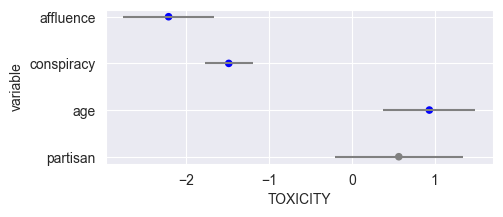

In [342]:
dep_var = 'TOXICITY'
indep_vars = ['conspiracy', 'affluence', 'age', 'partisan', #'sociality', 'time'
              ]
group='author'
md = smf.ols(f"{dep_var} ~ {'+'.join(indep_vars)}", data=to_regress_by_subreddit[[dep_var, group]+indep_vars].replace([np.inf, -np.inf], np.nan).dropna(axis=0).groupby([group]+indep_vars).mean().reset_index())
# md = smf.mixedlm(f"{dep_var} ~ {'+'.join(indep_vars)}", data=to_regress[[dep_var, group]+indep_vars].dropna(), groups=group)
mdf = md.fit()
print(mdf.summary())
plot_statsmodels(mdf, dep_var, (5, 2))

                            OLS Regression Results                            
Dep. Variable:             conspiracy   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     154.4
Date:                Tue, 05 Dec 2023   Prob (F-statistic):               0.00
Time:                        15:55:54   Log-Likelihood:             3.4799e+05
No. Observations:              835919   AIC:                        -6.958e+05
Df Residuals:                  835820   BIC:                        -6.946e+05
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.1654    

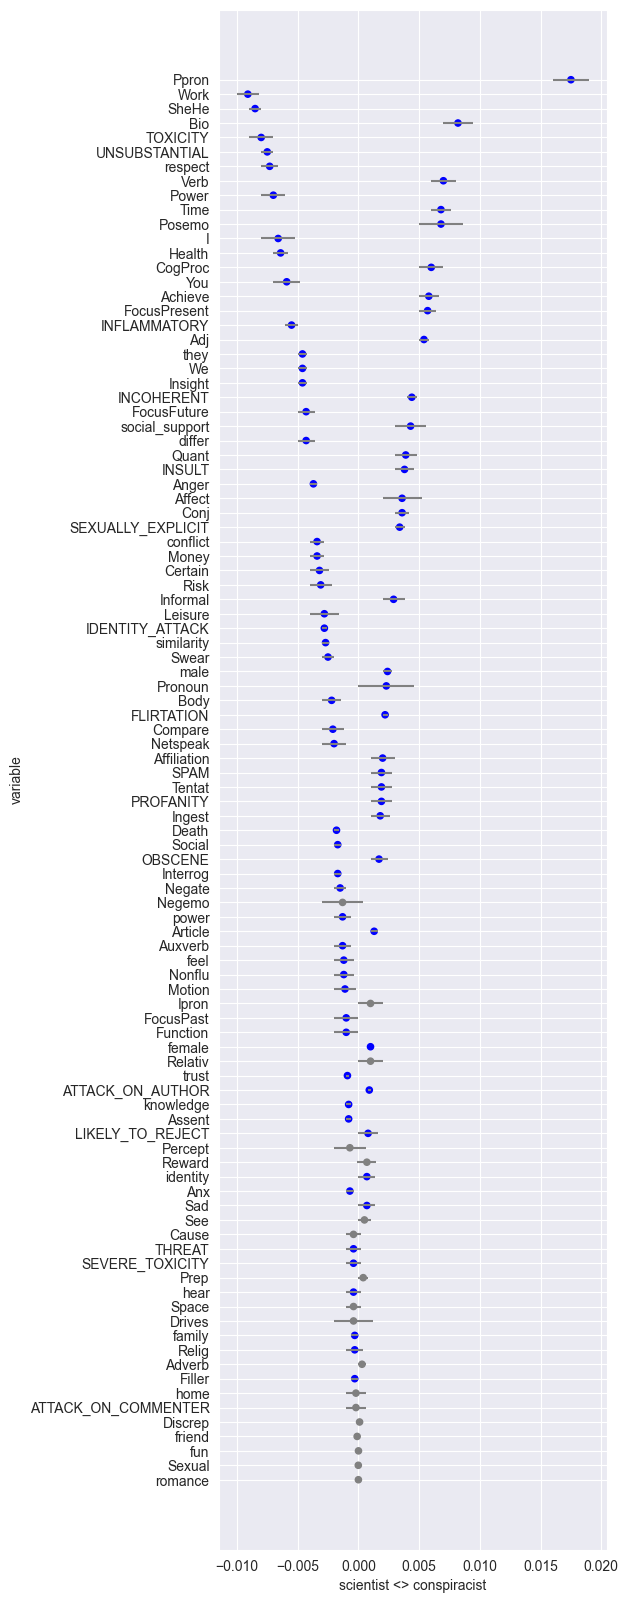

In [343]:
dep_var = 'conspiracy'
indep_vars = [i for i in liwc_cols if i in to_regress.columns]+toxic_cols+social_cols
group='author'
md = smf.ols(f"{dep_var} ~ {'+'.join(indep_vars)}", data=to_regress_by_subreddit[[dep_var, group]+indep_vars].replace([np.inf, -np.inf], np.nan).dropna(axis=0).groupby([group]+indep_vars).mean().reset_index())
# md = smf.mixedlm(f"{dep_var} ~ {'+'.join(indep_vars)}", data=to_regress[[dep_var, group]+indep_vars].dropna(), groups=group)
mdf = md.fit()
print(mdf.summary())
plot_statsmodels(mdf, 'scientist <> conspiracist')

                            OLS Regression Results                            
Dep. Variable:               partisan   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     78.92
Date:                Tue, 05 Dec 2023   Prob (F-statistic):               0.00
Time:                        15:56:41   Log-Likelihood:             1.2447e+06
No. Observations:              835919   AIC:                        -2.489e+06
Df Residuals:                  835820   BIC:                        -2.488e+06
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0164    

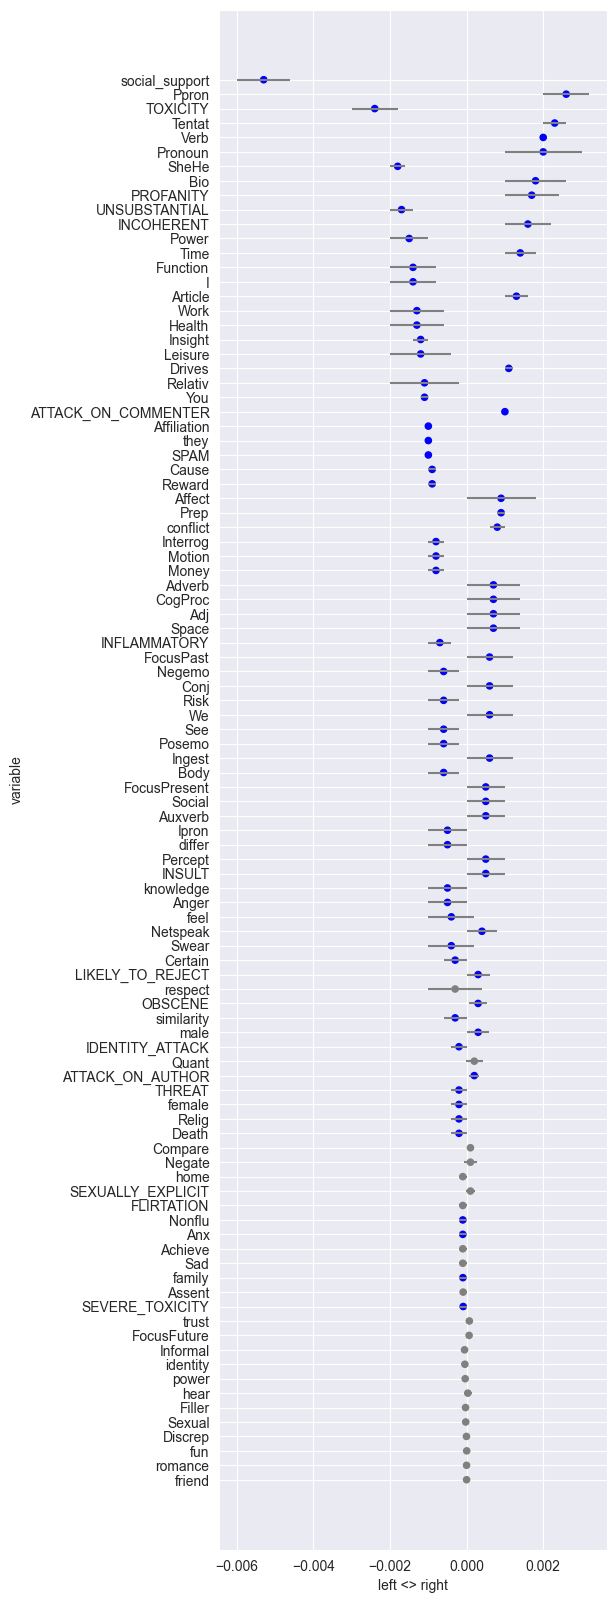

In [344]:
dep_var = 'partisan'
indep_vars = [i for i in liwc_cols if i in to_regress.columns]+toxic_cols+social_cols
group='author'
md = smf.ols(f"{dep_var} ~ {'+'.join(indep_vars)}", data=to_regress_by_subreddit[[dep_var, group]+indep_vars].replace([np.inf, -np.inf], np.nan).dropna(axis=0).groupby([group]+indep_vars).mean().reset_index())
# md = smf.mixedlm(f"{dep_var} ~ {'+'.join(indep_vars)}", data=to_regress[[dep_var, group]+indep_vars].dropna(), groups=group)
mdf = md.fit()
print(mdf.summary())
plot_statsmodels(mdf, 'left <> right')

In [320]:
to_regress_by_subreddit.TOXICITY.replace([np.inf, -np.inf], np.nan).dropna(axis=0).describe()

count    1.112440e+06
mean     8.469981e-01
std      1.088429e+01
min     -2.036429e+02
25%     -2.671398e-01
50%      3.158374e-01
75%      1.233163e+00
max      4.792253e+03
Name: TOXICITY, dtype: float64

In [341]:
to_regress_by_subreddit.replace([np.inf, -np.inf], np.nan).dropna(axis=0).describe()

,created_utc,ATTACK_ON_AUTHOR,ATTACK_ON_COMMENTER,FLIRTATION,IDENTITY_ATTACK,INCOHERENT,INFLAMMATORY,INSULT,LIKELY_TO_REJECT,OBSCENE,...,edginess,gender,gender B,gender neutral,partisan,partisan B,partisan B neutral,partisan neutral,sociality,time
count,8.373450e+05,837345.000000,837345.000000,837345.000000,837345.000000,837345.000000,837345.000000,837345.000000,837345.000000,837345.000000,...,837345.000000,837345.000000,837345.000000,837345.000000,837345.000000,837345.000000,837345.000000,837345.000000,837345.000000,837345.000000
mean,1.551644e+09,0.536457,0.639385,-0.130896,0.383606,-0.309005,0.786865,0.788033,0.178999,0.324898,...,0.035397,0.040949,0.062295,0.413847,0.025052,0.040158,0.418231,0.409478,-0.020030,0.057247
std,9.632699e+07,1.361853,1.295962,0.803142,1.540110,1.078650,1.020086,1.440883,1.097721,1.281661,...,0.054573,0.050031,0.057449,0.097057,0.054851,0.072539,0.112685,0.101346,0.074001,0.072572
min,1.135967e+09,-1.336410,-1.532586,-3.947069,-1.375578,-15.305308,-2.753701,-2.853102,-10.717858,-2.725700,...,-0.360177,-0.226925,-0.219464,0.000000,-0.302793,-0.410791,0.000000,0.000000,-0.442660,-0.404378
25%,1.488995e+09,-0.526062,-0.570027,-0.743314,-0.342353,-1.279929,0.051480,-0.306525,-0.695133,-0.622256,...,0.000963,0.009091,0.024249,0.380429,-0.001906,0.004277,0.370255,0.371104,-0.062669,0.017758
50%,1.580922e+09,-0.001001,0.304922,-0.194676,-0.170925,-0.255789,0.801535,0.155786,0.260649,-0.410045,...,0.032273,0.035826,0.055578,0.425798,0.025151,0.034088,0.412583,0.413240,-0.011280,0.058783
75%,1.629001e+09,1.286669,1.779494,0.374198,0.421010,0.517938,1.532713,1.697961,1.175882,1.517734,...,0.067847,0.067822,0.093483,0.470750,0.050345,0.066926,0.470926,0.463367,0.029259,0.098162
max,1.677629e+09,23.670076,16.323887,6.615117,164.414995,5.056178,7.150008,248.486365,3.056325,8.375209,...,0.494583,0.489725,0.532684,0.818038,0.444171,0.497002,0.813056,0.736924,0.425440,0.455239


(-1.0, 1.0)

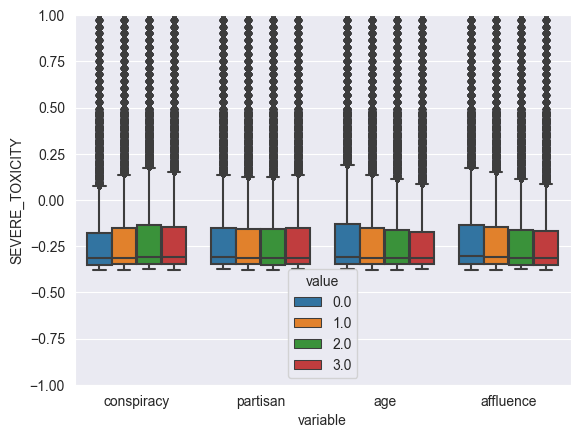

In [313]:
toplot = pd.concat((
    pd.qcut(to_regress.conspiracy, 4, labels=False),
    pd.qcut(to_regress.partisan, 4, labels=False),
    pd.qcut(to_regress.age, 4, labels=False),
    pd.qcut(to_regress.affluence, 4, labels=False),
    to_regress.SEVERE_TOXICITY),
    axis=1)
ax = sns.boxplot(toplot.melt(value_vars =['conspiracy', 'partisan', 'age', 'affluence'], id_vars=['SEVERE_TOXICITY']), y='SEVERE_TOXICITY', x='variable',
                 hue='value')
ax.set_ylim(-1, 1)

In [18]:
subreddit_topics = pd.read_excel('../data/processed/topic_analysis__50topics__subreddits.xlsx', sheet_name='top topic per subreddit').iloc[:, :3]
subreddit_topics.columns=['subreddit', 'topic', 'weight']

In [19]:
to_reformulate = (to_regress_by_subreddit[indep_vars]>0).replace({True:'high', False:'low'})
to_reformulate['topic'] = to_regress_by_subreddit.subreddit.map(subreddit_topics.set_index('subreddit').topic.astype('category').to_dict())
# to_reformulate['subreddit'] = to_regress_by_subreddit.subreddit
# to_reformulate = pd.merge(to_reformulate, dims_df[['affluence', 'age', 'partisan', 'gender', 'sociality', 'time']], left_on='subreddit', right_index=True, how='left')
to_reformulate = to_reformulate.groupby(['topic']).agg(pd.Series.mode).applymap(lambda x: 'same' if type(x)!=str else x)
to_reformulate.head()

NameError: name 'to_regress_by_subreddit' is not defined

In [235]:
from prince import FAMD, MCA ,PCA

In [224]:
mca = MCA(
    n_components=3,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca = mca.fit(to_reformulate)

In [226]:
mca.plot(to_reformulate)

alt.Chart(...)

In [233]:
to_reformulate = to_regress_by_subreddit[indep_vars].copy()
to_reformulate['topic'] = to_regress_by_subreddit.subreddit.map(subreddit_topics.set_index('subreddit').topic.astype('category').to_dict())
to_reformulate = to_reformulate.replace([np.inf, -np.inf], np.nan).dropna(axis=0).groupby('topic').mean()
to_reformulate.head()

,Adverb,Affect,Article,Auxverb,Cause,CogProc,Conj,Discrep,FocusPresent,Function,...,conflict,fun,identity,knowledge,power,respect,romance,similarity,social_support,trust
topic,,,,,,,,,,,,,,,,,,,,,
0.0,0.041607,-0.227050,0.225689,0.063876,-0.039129,-0.239243,0.133667,-0.089015,0.066242,-0.211266,...,1.645067,-0.453645,-0.437820,0.639857,-0.079818,-0.621053,-0.414186,-0.198739,-0.915072,-0.436322
1.0,0.023929,-0.234960,0.160396,0.130367,-0.060643,-0.336169,0.195589,-0.097342,0.174671,-0.341085,...,1.043895,-0.262318,-0.397980,0.760198,0.087751,-0.508583,-0.342329,-0.239462,-0.699314,-0.386865
2.0,-0.101467,-0.252211,0.216098,-0.029867,-0.075072,-0.329386,0.082652,-0.090700,-0.109472,-0.424572,...,1.334982,-0.305691,-0.461281,0.709536,-0.001733,-0.565801,-0.410284,-0.189707,-0.829684,-0.421449
3.0,-0.128727,-0.285749,-0.010496,-0.082518,-0.010647,-0.440476,-0.094773,-0.050023,-0.177994,-0.547327,...,1.324225,-0.019908,-0.147296,0.554766,0.011730,-0.376012,-0.030203,-0.188328,-0.685918,-0.375360
4.0,-0.048306,-0.287262,0.109852,0.086547,-0.080149,-0.411145,0.142806,-0.130217,0.066786,-0.354782,...,0.927312,-0.149664,-0.424413,0.553229,-0.079107,-0.515989,-0.299759,-0.172398,-0.695525,-0.368043


In [234]:
famd = FAMD(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    random_state=42,
    engine="sklearn",
    handle_unknown="error"  # same parameter as sklearn.preprocessing.OneHotEncoder
)
famd = famd.fit(to_reformulate)

ValueError: All variables are quantitative: PCA should be used

In [245]:
pca = PCA(
    n_components=3,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)

In [246]:
pca = pca.fit(to_reformulate.drop(9))

In [247]:
pca.scree_plot()

alt.Chart(...)

In [248]:
pca.plot(
    to_reformulate,
    x_component=0,
    y_component=1,
    # color_rows_by='continent',
    # show_row_markers=True,
    # show_column_markers=True,
    # show_row_labels=False,
    # row_labels_column=None,  # for DataFrames with a MultiIndex
    # show_column_labels=False
)

alt.LayerChart(...)

In [244]:
to_reformulate.drop(9)

,Adverb,Affect,Article,Auxverb,Cause,CogProc,Conj,Discrep,FocusPresent,Function,...,conflict,fun,identity,knowledge,power,respect,romance,similarity,social_support,trust
topic,,,,,,,,,,,,,,,,,,,,,
0.0,0.041607,-0.227050,0.225689,0.063876,-0.039129,-0.239243,0.133667,-0.089015,0.066242,-0.211266,...,1.645067,-0.453645,-0.437820,0.639857,-0.079818,-0.621053,-0.414186,-0.198739,-0.915072,-0.436322
1.0,0.023929,-0.234960,0.160396,0.130367,-0.060643,-0.336169,0.195589,-0.097342,0.174671,-0.341085,...,1.043895,-0.262318,-0.397980,0.760198,0.087751,-0.508583,-0.342329,-0.239462,-0.699314,-0.386865
2.0,-0.101467,-0.252211,0.216098,-0.029867,-0.075072,-0.329386,0.082652,-0.090700,-0.109472,-0.424572,...,1.334982,-0.305691,-0.461281,0.709536,-0.001733,-0.565801,-0.410284,-0.189707,-0.829684,-0.421449
3.0,-0.128727,-0.285749,-0.010496,-0.082518,-0.010647,-0.440476,-0.094773,-0.050023,-0.177994,-0.547327,...,1.324225,-0.019908,-0.147296,0.554766,0.011730,-0.376012,-0.030203,-0.188328,-0.685918,-0.375360
4.0,-0.048306,-0.287262,0.109852,0.086547,-0.080149,-0.411145,0.142806,-0.130217,0.066786,-0.354782,...,0.927312,-0.149664,-0.424413,0.553229,-0.079107,-0.515989,-0.299759,-0.172398,-0.695525,-0.368043
6.0,-0.050561,-0.293994,0.270773,-0.041337,-0.010832,-0.266597,0.084914,-0.133471,-0.083855,-0.371320,...,1.118974,-0.296124,-0.385993,0.855329,-0.010846,-0.549879,-0.392823,-0.122831,-0.782205,-0.388145
7.0,-0.024103,-0.273090,0.153723,-0.007656,-0.080991,-0.392716,0.142938,-0.086760,-0.059034,-0.484997,...,1.191923,-0.287499,-0.441170,0.671080,0.077412,-0.510586,3.611914,-0.185581,-0.730498,-0.401992
8.0,0.041084,-0.245512,0.241331,0.073824,-0.082747,-0.286385,0.208633,-0.075533,0.010818,-0.271952,...,1.045624,-0.296863,-0.491288,0.616132,-0.149294,-0.590596,-0.385841,-0.287628,-0.842340,-0.449355
10.0,0.095674,-0.203748,0.096473,0.154674,0.015104,-0.217219,0.260212,-0.000749,0.190608,-0.210579,...,1.132273,-0.401398,-0.594989,0.733710,-0.248798,-0.732233,-0.492873,-0.367055,-0.913994,-0.538652


In [325]:
to_regress.head()

,author,created_utc,subreddit,text,fullname,parent_fullname,link_fullname,ATTACK_ON_AUTHOR,ATTACK_ON_COMMENTER,FLIRTATION,...,edginess,gender,gender B,gender neutral,partisan,partisan B,partisan B neutral,partisan neutral,sociality,time
16063,martin77,1135966642,reddit.com,would the person who marked this post down\r\n...,t1_c2608,t3_22406,t3_22406,-0.535118,1.401719,-0.533599,...,0.008995,0.136209,0.055589,0.502465,-0.023369,-0.084986,0.347631,0.400243,-0.325850,-0.394882
16064,madmonky1,1137434271,reddit.com,"&gt;Any other rational person, who isn't too f...",t1_c6146,t1_c6070,t3_27340,-0.265519,-1.250158,-0.900417,...,0.008995,0.136209,0.055589,0.502465,-0.023369,-0.084986,0.347631,0.400243,-0.325850,-0.394882
16065,bigheadarmy,1138919169,reddit.com,"With regard to the blathering, my dismissal co...",t1_c17zz,t1_c17z7,t3_17mn,-0.948709,-1.244978,0.838086,...,0.008995,0.136209,0.055589,0.502465,-0.023369,-0.084986,0.347631,0.400243,-0.325850,-0.394882
16066,the_seanald,1139327062,reddit.com,What do you say to all these conspiracy theori...,t1_c1bq8,t3_1b0p,t3_1b0p,-0.787254,0.996547,-0.966945,...,0.008995,0.136209,0.055589,0.502465,-0.023369,-0.084986,0.347631,0.400243,-0.325850,-0.394882
16067,Alex3917,1144197420,reddit.com,Jon Ronson devoted a large part of his book on...,t1_c3xes,t3_3x9b,t3_3x9b,1.050138,-0.849214,-1.283120,...,0.011291,0.131207,0.053512,0.498045,-0.020472,-0.077343,0.346098,0.396380,-0.317117,-0.383990


In [338]:
dfm = df[[i for i in liwc_cols+toxic_cols+social_cols+['author'] if i in to_regress_by_subreddit.columns]].groupby('author').mean()

In [339]:
pd.merge((subreddit_means.TOXICITY-dfm.TOXICITY).sort_values(), user_df, left_index=True, right_index=True).dropna().corr()

,TOXICITY,conspiracy,affluence,age,age B,age neutral,edginess,gender,gender B,gender neutral,partisan,partisan B,partisan B neutral,partisan neutral,sociality,time
TOXICITY,1.000000,-0.055329,-0.186833,0.087187,0.059731,-0.005407,0.227842,-0.019710,-0.024370,0.003851,-0.032001,-0.055105,0.040018,0.071645,-0.104014,-0.161212
conspiracy,-0.055329,1.000000,-0.169953,-0.005763,0.047727,0.220673,0.409214,0.197465,0.159439,0.184748,0.296468,0.517177,0.456222,0.356280,0.031123,0.329451
affluence,-0.186833,-0.169953,1.000000,0.544851,0.350978,0.549331,-0.200275,0.183246,0.021713,0.555851,0.033631,-0.139083,0.300768,0.310353,-0.419841,-0.395491
age,0.087187,-0.005763,0.544851,1.000000,0.908722,0.323215,0.057484,0.297485,-0.097134,0.351200,-0.376462,-0.256918,0.432785,0.437220,-0.761989,-0.553097
age B,0.059731,0.047727,0.350978,0.908722,1.000000,0.158375,-0.084195,0.277933,-0.187986,0.178561,-0.416217,-0.162468,0.369168,0.335202,-0.587618,-0.321693
age neutral,-0.005407,0.220673,0.549331,0.323215,0.158375,1.000000,0.275996,0.412699,0.485365,0.991945,0.131065,0.041344,0.836000,0.872793,-0.245599,-0.122182
edginess,0.227842,0.409214,-0.200275,0.057484,-0.084195,0.275996,1.000000,0.085900,0.231469,0.263956,0.323670,0.192781,0.339074,0.373809,-0.321028,-0.247733
gender,-0.019710,0.197465,0.183246,0.297485,0.277933,0.412699,0.085900,1.000000,0.784889,0.449135,-0.282023,-0.290505,0.376176,0.395340,-0.279997,-0.314130
gender B,-0.024370,0.159439,0.021713,-0.097134,-0.187986,0.485365,0.231469,0.784889,1.000000,0.532629,-0.134467,-0.185145,0.331976,0.375201,0.020170,-0.091542
gender neutral,0.003851,0.184748,0.555851,0.351200,0.178561,0.991945,0.263956,0.449135,0.532629,1.000000,0.075586,0.014529,0.818776,0.855752,-0.248151,-0.147809


In [336]:
to_regress_by_subreddit.head()

,author,created_utc,subreddit,text,fullname,parent_fullname,link_fullname,ATTACK_ON_AUTHOR,ATTACK_ON_COMMENTER,FLIRTATION,...,edginess,gender,gender B,gender neutral,partisan,partisan B,partisan B neutral,partisan neutral,sociality,time
16063,martin77,1135966642,reddit.com,would the person who marked this post down\r\n...,t1_c2608,t3_22406,t3_22406,-0.191961,2.673818,-0.514330,...,0.008995,0.136209,0.055589,0.502465,-0.023369,-0.084986,0.347631,0.400243,-0.325850,-0.394882
16064,madmonky1,1137434271,reddit.com,"&gt;Any other rational person, who isn't too f...",t1_c6146,t1_c6070,t3_27340,0.151600,-0.936964,-0.788143,...,0.008995,0.136209,0.055589,0.502465,-0.023369,-0.084986,0.347631,0.400243,-0.325850,-0.394882
16065,bigheadarmy,1138919169,reddit.com,"With regard to the blathering, my dismissal co...",t1_c17zz,t1_c17z7,t3_17mn,-0.719018,-0.929911,0.509572,...,0.008995,0.136209,0.055589,0.502465,-0.023369,-0.084986,0.347631,0.400243,-0.325850,-0.394882
16066,the_seanald,1139327062,reddit.com,What do you say to all these conspiracy theori...,t1_c1bq8,t3_1b0p,t3_1b0p,-0.513269,2.122137,-0.837803,...,0.008995,0.136209,0.055589,0.502465,-0.023369,-0.084986,0.347631,0.400243,-0.325850,-0.394882
16067,Alex3917,1144197420,reddit.com,Jon Ronson devoted a large part of his book on...,t1_c3xes,t3_3x9b,t3_3x9b,1.828198,-0.391042,-1.073814,...,0.011291,0.131207,0.053512,0.498045,-0.020472,-0.077343,0.346098,0.396380,-0.317117,-0.383990
